In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/QBIO\ 465\ FP/Original /content/

In [ ]:
!pip install torchinfo

In [ ]:
import os
import torch
import torchvision
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import ViT_B_16_Weights
from torchinfo import summary

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_dir = "/content/Original"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

In [ ]:
device

device(type='cuda')

In [ ]:
vit_weights = ViT_B_16_Weights.DEFAULT
vit_transforms = vit_weights.transforms()

In [ ]:
def create_dataloaders(train_dir, test_dir, transform, batch_size=32):
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_data.classes

In [ ]:
import os
import shutil
import random

def split_dataset(original_root, train_root, test_root, split_ratio=0.8):
    classes = ['Benign', 'Early', 'Pre', 'Pro']
    for cls in classes:
        original_folder = os.path.join(original_root, cls)
        images = [f for f in os.listdir(original_folder) if f.endswith('.jpg')]
        random.shuffle(images)

        split_index = int(len(images) * split_ratio)
        train_images = images[:split_index]
        test_images = images[split_index:]

        os.makedirs(os.path.join(train_root, cls), exist_ok=True)
        os.makedirs(os.path.join(test_root, cls), exist_ok=True)

        for img in train_images:
            src = os.path.join(original_folder, img)
            dst = os.path.join(train_root, cls, img)
            shutil.copy(src, dst)

        for img in test_images:
            src = os.path.join(original_folder, img)
            dst = os.path.join(test_root, cls, img)
            shutil.copy(src, dst)

split_dataset(
    original_root='/content/Original',
    train_root='/content/Original/train',
    test_root='/content/Original/test',
    split_ratio=0.8
)


In [ ]:
train_loader, test_loader, class_names = create_dataloaders(
    train_dir, test_dir, vit_transforms, batch_size=32
)

In [ ]:
vit = torchvision.models.vit_b_16(weights=vit_weights).to(device)

for param in vit.parameters():
    param.requires_grad = False

vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit.heads.parameters(), lr=1e-3)

In [ ]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

def train_model(model, train_loader, test_loader, loss_fn, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_train_loss, correct_train, total_train = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)

        train_acc = correct_train / total_train
        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracies.append(train_acc)
        train_losses.append(avg_train_loss)

        model.eval()
        total_test_loss, correct_test, total_test = 0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                total_test_loss += loss.item()
                correct_test += (outputs.argmax(1) == labels).sum().item()
                total_test += labels.size(0)

        test_acc = correct_test / total_test
        avg_test_loss = total_test_loss / len(test_loader)
        test_accuracies.append(test_acc)
        test_losses.append(avg_test_loss)

        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Train Acc={train_acc:.4f}, Test Acc={test_acc:.4f}")


In [ ]:
train_model(vit, train_loader, test_loader, loss_fn, optimizer, epochs=15)

Epoch 1: Train Loss=0.4748, Train Acc=0.8570, Test Acc=0.9659
Epoch 2: Train Loss=0.1653, Train Acc=0.9680, Test Acc=0.9770
Epoch 3: Train Loss=0.1103, Train Acc=0.9766, Test Acc=0.9813
Epoch 4: Train Loss=0.0852, Train Acc=0.9814, Test Acc=0.9889
Epoch 5: Train Loss=0.0681, Train Acc=0.9866, Test Acc=0.9898
Epoch 6: Train Loss=0.0585, Train Acc=0.9898, Test Acc=0.9915
Epoch 7: Train Loss=0.0506, Train Acc=0.9910, Test Acc=0.9932
Epoch 8: Train Loss=0.0451, Train Acc=0.9920, Test Acc=0.9932
Epoch 9: Train Loss=0.0396, Train Acc=0.9930, Test Acc=0.9923
Epoch 10: Train Loss=0.0369, Train Acc=0.9926, Test Acc=0.9923
Epoch 11: Train Loss=0.0326, Train Acc=0.9936, Test Acc=0.9932
Epoch 12: Train Loss=0.0295, Train Acc=0.9939, Test Acc=0.9932
Epoch 13: Train Loss=0.0274, Train Acc=0.9946, Test Acc=0.9932
Epoch 14: Train Loss=0.0254, Train Acc=0.9946, Test Acc=0.9940
Epoch 15: Train Loss=0.0239, Train Acc=0.9955, Test Acc=0.9949


In [ ]:
torch.save(vit.state_dict(), "/content/drive/MyDrive/QBIO 465 FP/vit_model.pth")

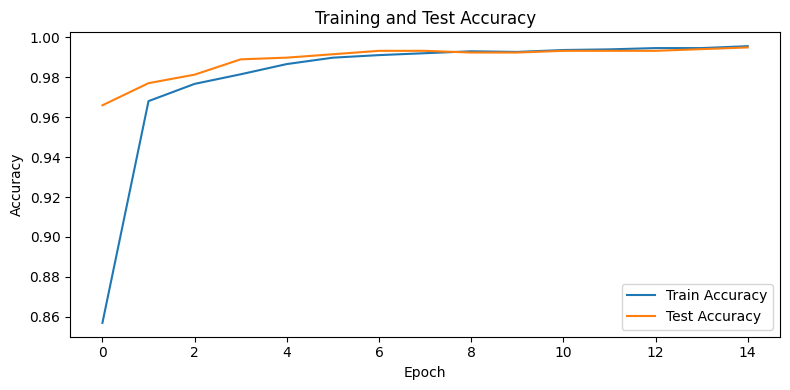

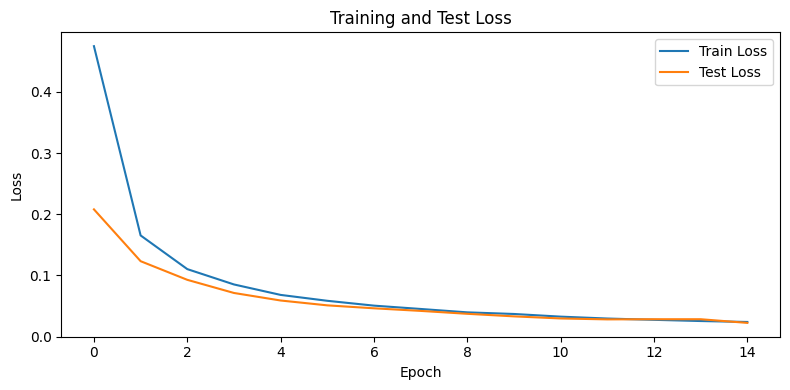

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(8,4))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Loss
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.tight_layout()
plt.show()


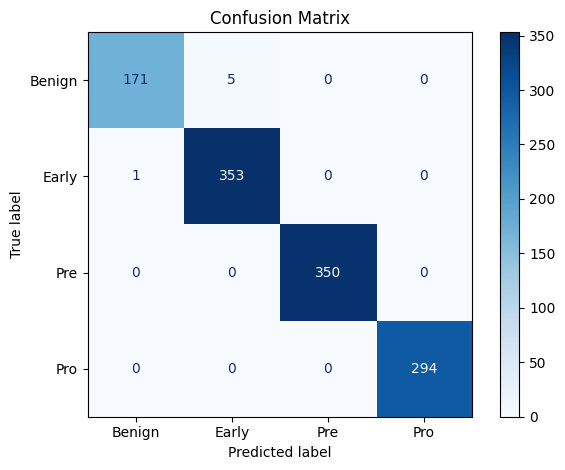

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import torch.nn.functional as F
import numpy as np

all_preds = []
all_probs = []
all_labels = []

vit.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vit(images)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


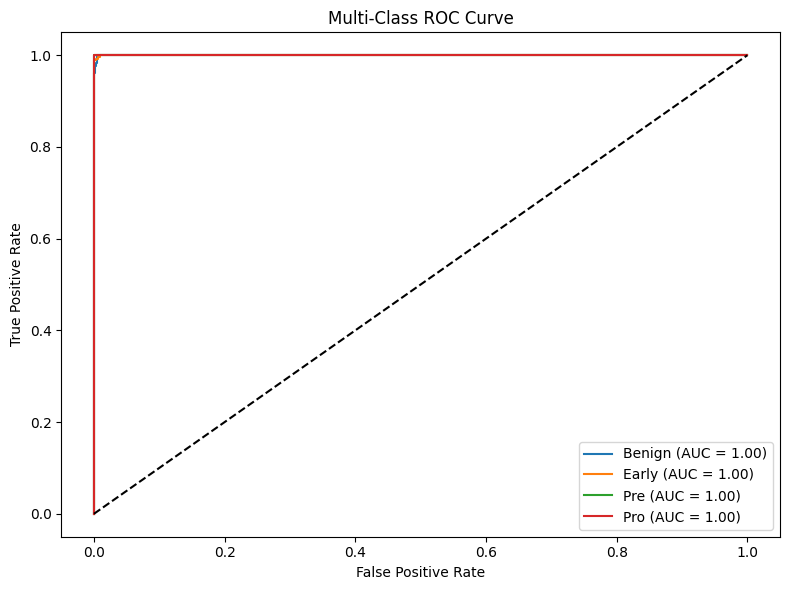

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
y_score = np.array(all_probs)

plt.figure(figsize=(8,6))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [ ]:
vit = torchvision.models.vit_b_16(weights=ViT_B_16_Weights.DEFAULT).to(device)

for param in vit.parameters():
    param.requires_grad = False

vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

vit.load_state_dict(torch.load("/content/drive/MyDrive/QBIO 465 FP/vit_model.pth"))
vit.eval()

from sklearn.metrics import classification_report

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = vit(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 229MB/s]


              precision    recall  f1-score   support

      Benign       1.00      0.97      0.98       101
       Early       0.98      1.00      0.99       197
         Pre       1.00      1.00      1.00       193
         Pro       1.00      1.00      1.00       161

    accuracy                           1.00       652
   macro avg       1.00      0.99      0.99       652
weighted avg       1.00      1.00      1.00       652

